<a href="https://colab.research.google.com/github/ArnovanHilten/PatchClampClassifier/blob/main/Saved_Classifier_patchclamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Runtime > run all or shift+enter to run the cells


## How to classify poly vs mono

*   0.2 to 0.6 is time of interest
*   classify between mono and poly


*   block signal stimulus (second channel)
*   time for it to repond (shorter for mono; 3 ms 15 ms ; poly > 15ms  60ms after event)



*   start point for poly is less consistent over the sweeps
*   jitter





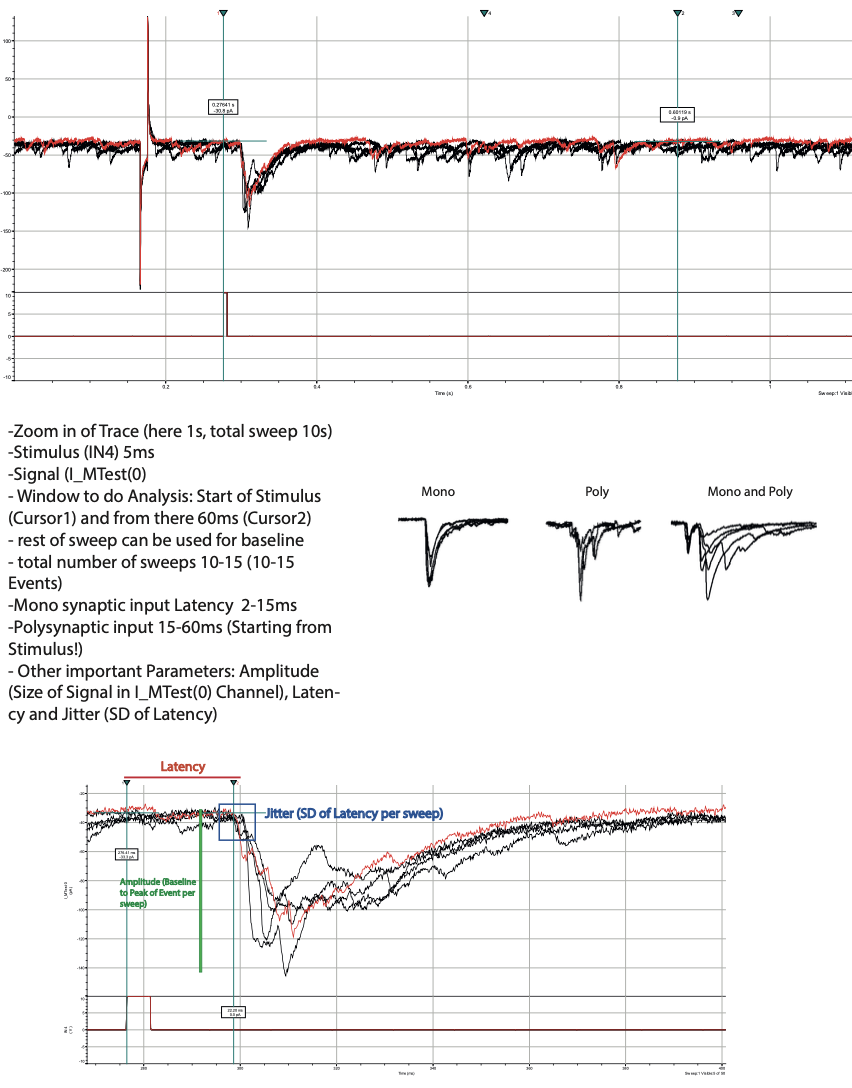

# Init

In [ ]:
pip install --upgrade pyabf

In [ ]:
# when you run this a new pop-up opens and you need to accept colabs permissions to drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path to the data
drive_path = 'drive/MyDrive/Postdoc/data_juliet/'

# Process metadata

In [ ]:
import pyabf
import scipy
import pyabf
from scipy.signal import savgol_filter
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
from scipy.signal import welch
from scipy import signal
from scipy.signal import butter, lfilter



# metadata = pd.read_csv("metadata.csv")
# metadata_df = metadata.ffill()
# metadata_df

# # Forward filling the 'Date/filename' column and replacing "/" with "_"
# metadata_df['Date/filename'] = metadata_df['Date/filename'].fillna(method='ffill')
# metadata_df['Date_filename_modified'] = metadata_df['Date/filename'].str.replace('/', '_')

# # Changing the type of 'Date/filename' column to date
# metadata_df['Date/filename'] = pd.to_datetime(metadata_df['Date/filename'], format='%d/%m/%Y')
# metadata_df["Class"] = (metadata_df["Input"] == "Poly")*1
# # Attempting again to reformat 'Date/filename' to 'year_month_day' format for 'Date_filename_modified'
# metadata_df['Date_filename_modified'] = metadata_df['Date/filename'].dt.strftime('%Y_%m_%d')
# metadata_df.head()

# metadata_df["filename"] = metadata_df["Date_filename_modified"].values + "_" + metadata_df["recordings"].str.replace("rec","0").values
# metadata_df

# metadata_df.to_csv("drive/MyDrive/Postdoc/data_juliet/metadata.csv", index=False)

metadata = pd.read_csv("drive/MyDrive/Postdoc/data_juliet/metadata.csv")


metadata.head()


,Date/filename,recordings,Cell Ids for me,Line,Input,Date_filename_modified,Class,filename
0,01/02/2022,rec004,1,Vglut2,Poly,2022_02_01,1,2022_02_01_0004
1,01/02/2022,rec007,2,Vglut2,Mono,2022_02_01,0,2022_02_01_0007
2,01/02/2022,rec015,3,Vglut2,Poly,2022_02_01,1,2022_02_01_0015
3,01/02/2022,rec022,4,Vglut2,Mono,2022_02_01,0,2022_02_01_0022
4,01/02/2022,rec029,5,Vglut2,Mono,2022_02_01,0,2022_02_01_0029


In [ ]:

def check_single_pulse(abf):
  normC= abs(abf.sweepC) - abs(abf.sweepC[0])
  first_pulse = np.argmax(normC)

  for i in range(first_pulse, normC.shape[0]):
      if normC[i] == normC[first_pulse]:
        pass
      else:
        end_first_pulse = i
        break

  for i in range(end_first_pulse, normC.shape[0]):
      if normC[i] == normC[end_first_pulse]:
        pass
      else:
        print("new signal detected at", i)
        return False
        break
  return True

def low_pass_filter(data, cutoff, fs, order=5):
    """
    Apply a low pass Butterworth filter.

    Parameters:
    - data : array_like, The data to filter.
    - cutoff : float, The cutoff frequency of the filter.
    - fs : float, The sampling rate of the data.
    - order : int, The order of the filter.

    Returns:
    - filtered_data : array_like, The filtered data.
    """
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

def correct_abf_signal(abf):
    sweepynorm = []
    for i in range(abf.sweepCount):
      # Assuming you are working with the first channel and first sweep
      abf.setSweep(sweepNumber=i)
      baseline = abf.sweepY[:np.argmax(abs(abf.sweepC))].mean() # take before the peak to correct offset
      sweepynorm.append((abf.sweepY - baseline) )
    sweepynormed = np.vstack(sweepynorm)
    return sweepynormed

def smooth_abf_signal(Ysignal,  window_size = 21, poly_order = 3 ):
  smoothed_signal = []
  for i in range(Ysignal.shape[0]):
    smoothed_signal.append(savgol_filter(Ysignal[i,:], window_size, poly_order))
  smoothed_signal = np.vstack(smoothed_signal)
  return smoothed_signal

def norm_abf_signal(Ysignal, pulse_offset = 400, end_time = 6000):
    sweepynorm = []
    start_pulse = np.argmax(abs(abf.sweepC)) + pulse_offset

    Ysignal = Ysignal[:, start_pulse:end_time]
    for i in range(Ysignal.shape[0]):
      norm_max = max(abs(Ysignal[i,:]))
      print(norm_max)
      sweepynorm.append(Ysignal[i,:] / (norm_max + 0.000001) )

    sweepynorm = np.vstack(sweepynorm)
    return sweepynorm


def extract_features(signals, start_pulse_signal):
    features_list = []

    for s in signals:
        _, psd = welch(s)
        psd_norm = psd / np.sum(psd)
        # Calculate the statistical features for each signal
        fft_results = fft(s)

        # Get the absolute value to find the magnitude of the frequencies
        fft_magnitudes = np.abs(fft_results)

        # Since FFT output is symmetrical, we take the first half of the frequencies
        # which represent the frequency spectrum from 0 to the Nyquist frequency
        half_n_samples = signals.shape[1] // 2
        fft_magnitudes = fft_magnitudes[:half_n_samples]

        # Feature 1: The maximum magnitude (the peak in the FFT)
        max_magnitude = np.max(fft_magnitudes)

        # Feature 2: The frequency at which the maximum magnitude occurs
        max_freq_index = np.argmax(fft_magnitudes)


        features_dict = {
            'min/amplitude': np.min(s),
            'max': np.max(s),
            'integral': np.trapz(-s),
            'time_onset_peak': np.argmin(np.diff(s)) - start_pulse_signal,
            'time_onset_max_peak': np.argmax(np.diff(s)) - start_pulse_signal,
            'time_max': np.argmax(s) - start_pulse_signal,
            'mean': np.mean(s),
            'median': np.median(s),
            'std_dev': np.std(s),
            'skewness': skew(s),
            'energy': np.sum(np.square(s)),
            'spectral_entropy': -np.sum(psd_norm * np.log2(psd_norm)),
            'peak_to_peak': np.ptp(s),
            'autocorr_feature': np.correlate(s, s, mode='full')[len(s)-1],
            'peaks_count_p1': len(signal.find_peaks(-s, prominence=100, distance=100)[0]),
            'peaks_count_p2': len(signal.find_peaks(-s, prominence=50, distance=200)[0]),
            'peaks_count_p3': len(signal.find_peaks(-s, prominence=100)[0]),
            'peaks_count_p4': len(signal.find_peaks(-s, prominence=50)[0]),
            'max_magnitude':max_magnitude,
            'max_freq_index':max_freq_index

        }
        features_list.append(features_dict)

    # Convert the list of feature dictionaries to a DataFrame
    features_df = pd.DataFrame(features_list)

    return features_df




# Plot data

Time to signal: 0.16620000000000001 seconds
Time to neuron peak: 0.1665 seconds


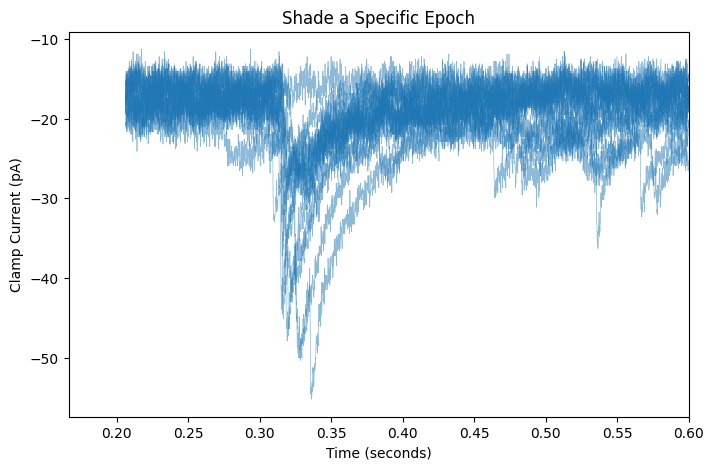

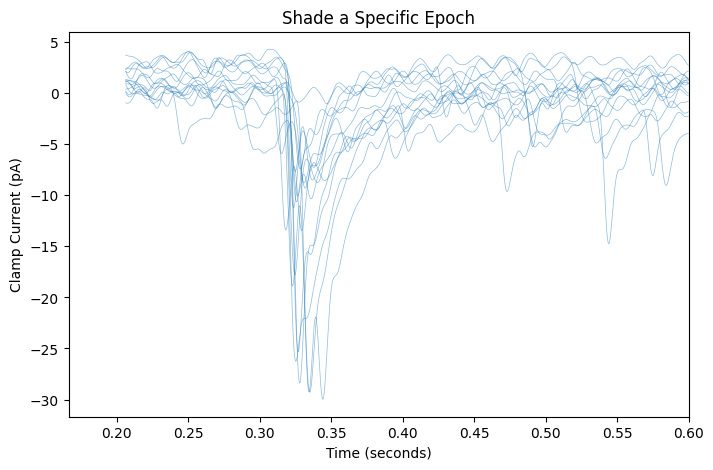

In [ ]:
# Just looking at a single ABF
abf = []
end_time = 6000
cutoff = 100
fs = 10000

# change here the path if you want to inspect a different one
abf = pyabf.ABF(drive_path + "2022_02_01_0015.abf")





if not(check_single_pulse(abf)):
  print("error")
start_pulse = np.argmax(abs(abf.sweepC)) + 400
start_pulse_signal = np.argmax(abs(abf.sweepC))
pulse_signal = np.argmax(abs(abf.sweepC)) * abf.dataSecPerPoint
time_to_peak = np.argmax(abs(abf.sweepY)) * abf.dataSecPerPoint

# Output the result
print("Time to signal:", pulse_signal, "seconds")
print("Time to neuron peak:", time_to_peak, "seconds")

corrected_signal = correct_abf_signal(abf)
lowpass_signal = low_pass_filter(corrected_signal, cutoff, fs)

smoothend_signal = smooth_abf_signal(corrected_signal)
# norm_signal = norm_abf_signal(corrected_signal)

plt.figure(figsize=(8, 5))
for sweepNumber in abf.sweepList:
    abf.setSweep(sweepNumber)
    plt.plot(abf.sweepX[start_pulse:end_time], abf.sweepY[start_pulse:end_time], color='C0', alpha=.5, lw=.5,label="sweep %d" % (sweepNumber))
plt.ylabel(abf.sweepLabelY)
plt.xlabel(abf.sweepLabelX)
plt.title("Shade a Specific Epoch")
plt.xlim([pulse_signal, 0.6])
plt.show()


plt.figure(figsize=(8, 5))
for sweepNumber in abf.sweepList:
    abf.setSweep(sweepNumber)
    plt.plot(abf.sweepX[start_pulse:end_time], lowpass_signal[sweepNumber,start_pulse:end_time], color='C0', alpha=.5, lw=.5,label="sweep %d" % (sweepNumber))
plt.ylabel(abf.sweepLabelY)
plt.xlabel(abf.sweepLabelX)
plt.title("Shade a Specific Epoch")
plt.xlim([pulse_signal, 0.6])
plt.show()



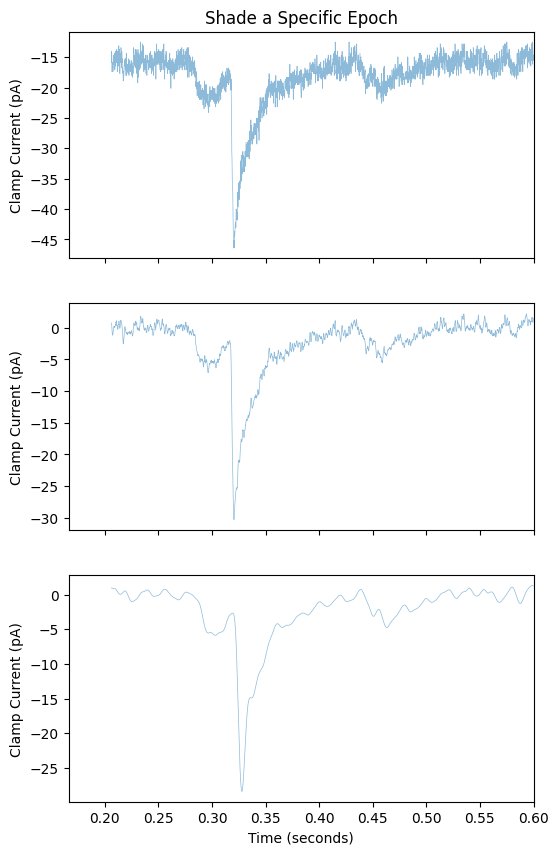

In [ ]:
# shows an individual sweep

sweepNumber = 12

# Create a figure with 3 subplots sharing the x-axis
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# First subplot
abf.setSweep(sweepNumber)
axs[0].plot(abf.sweepX[start_pulse:end_time], abf.sweepY[start_pulse:end_time], color='C0', alpha=.5, lw=.5, label="sweep %d" % sweepNumber)
axs[0].set_ylabel(abf.sweepLabelY)
axs[0].set_title("Shade a Specific Epoch")
axs[0].set_xlim([pulse_signal, 0.6])

# Second subplot

axs[1].plot(abf.sweepX[start_pulse:end_time], smoothend_signal[sweepNumber, start_pulse:end_time], color='C0', alpha=.5, lw=.5, label="sweep %d" % sweepNumber)
axs[1].set_ylabel(abf.sweepLabelY)

# Third subplot
abf.setSweep(sweepNumber)
axs[2].plot(abf.sweepX[start_pulse:end_time], lowpass_signal[sweepNumber, start_pulse:end_time], color='C0', alpha=.5, lw=.5, label="sweep %d" % sweepNumber)
axs[2].set_ylabel(abf.sweepLabelY)
axs[2].set_xlabel(abf.sweepLabelX)

# Show the plot
plt.show()

# Get features for all ABF files

In [ ]:
total_features = []
import tqdm
for filename in tqdm.tqdm(metadata["filename"]):

  abf = pyabf.ABF(drive_path + "/"+str(filename)+".abf")

  if not(check_single_pulse(abf)):
    print("error")

  pulse_signal = np.argmax(abs(abf.sweepC)) * abf.dataSecPerPoint
  time_to_peak = np.argmax(abs(abf.sweepY)) * abf.dataSecPerPoint

  corrected_signal = correct_abf_signal(abf)
  lowpass_signal = low_pass_filter(corrected_signal,cutoff, fs)
  smoothend_signal = smooth_abf_signal(corrected_signal)

  s = lowpass_signal[:,start_pulse:end_time]
  pd_features_signal_low = extract_features(s, start_pulse_signal)
  features_signal_low = np.concatenate([pd_features_signal_low.mean(0).values, pd_features_signal_low.std(0).values])
  s = corrected_signal[:,start_pulse:end_time]
  pd_features_signal_raw = extract_features(s, start_pulse_signal)
  features_signal_raw = np.concatenate([pd_features_signal_raw.mean(0).values, pd_features_signal_raw.std(0).values])
  s = smoothend_signal[:,start_pulse:end_time]
  pd_features_signal = extract_features(s, start_pulse_signal)
  features_signal_smooth = np.concatenate([pd_features_signal.mean(0).values, pd_features_signal.std(0).values])
  features_signal = np.concatenate([features_signal_raw, features_signal_smooth, features_signal_low, ])


  total_features.append(features_signal)

pd_features = pd.DataFrame(total_features)
feature_columns = list(pd_features_signal_raw.columns) + ["std_"+ x for x in list(pd_features_signal_raw.columns) ]
total_feature_columns = ["raw_"+ x for x in list(feature_columns) ] + ["smooth_"+ x for x in list(feature_columns)  ]+ ["low_"+ x for x in list(feature_columns)  ]
pd_features


100%|██████████| 251/251 [02:24<00:00,  1.74it/s]


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-1078.962769,9.334658,65911.078125,-435.666667,-269.866667,-1298.200000,-16.738073,-4.896706,80.272942,-9.082244,...,1.379604e+07,0.175416,291.292884,1.379604e+07,0.632456,0.593617,0.632456,1.069045,24463.971809,0.560612
1,-465.439056,9.251698,255882.312500,-447.266667,-398.600000,-1323.866667,-64.982498,-57.276619,60.371769,-2.250535,...,9.591535e+06,0.132428,98.943481,9.591535e+06,0.487950,0.798809,0.487950,0.774597,42631.884264,0.000000
2,-18.536425,5.145217,3464.653809,457.200000,-249.533333,-808.266667,-0.879610,0.058954,3.539373,-1.868778,...,5.984479e+04,0.152138,9.276057,5.984479e+04,0.000000,0.000000,0.000000,0.000000,3497.129846,0.593617
3,-151.882843,8.741334,70522.640625,-671.933333,-391.266667,-1068.866667,-17.908239,-7.361775,29.578180,-2.402715,...,3.698551e+06,0.168514,54.665924,3.698551e+06,0.516398,0.593617,0.516398,0.593617,35204.029813,0.560612
4,-53.944523,7.029596,29212.740234,-82.666667,-390.400000,-715.066667,-7.419096,-4.088976,10.567999,-1.784961,...,3.530852e+05,0.105350,15.415467,3.530852e+05,0.000000,0.487950,0.000000,0.487950,10263.311999,0.258199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,-56.581173,8.645056,7276.387207,-419.800000,-514.066667,372.333333,-1.847623,0.100134,7.416011,-2.919498,...,1.865695e+05,0.095645,15.366501,1.865695e+05,0.000000,0.632456,0.000000,0.632456,6571.555779,0.910259
247,-82.923531,9.544730,25016.835938,-429.133333,-83.466667,-150.533333,-6.353186,-1.319527,15.816957,-2.278612,...,4.060545e+06,0.102218,80.449919,4.060545e+06,0.258199,0.593617,0.258199,0.593617,24137.605783,1.290994
248,-41.642075,9.240901,9207.004883,-60.200000,-1091.733333,-258.266667,-2.338493,-0.097478,7.905810,-1.824886,...,2.098448e+05,0.119273,17.265365,2.098448e+05,0.000000,0.593617,0.000000,0.593617,5392.980532,1.162919
249,-91.038651,4.817065,45617.230469,-572.700000,488.900000,-1044.800000,-11.584661,-7.023755,16.181263,-2.419635,...,8.596436e+05,0.098170,20.550504,8.596436e+05,0.421637,0.000000,0.421637,0.000000,22486.369794,0.000000


# Classification

In [ ]:
# The input features
pd_features.columns = total_feature_columns
pd_features

,raw_min,raw_max,raw_integral,raw_time_onset_peak,raw_time_onset_max_peak,raw_time_max,raw_mean,raw_median,raw_std_dev,raw_skewness,...,low_std_energy,low_std_spectral_entropy,low_std_peak_to_peak,low_std_autocorr_feature,low_std_peaks_count_p1,low_std_peaks_count_p2,low_std_peaks_count_p3,low_std_peaks_count_p4,low_std_max_magnitude,low_std_max_freq_index
0,-1078.962769,9.334658,65911.078125,-435.666667,-269.866667,-1298.200000,-16.738073,-4.896706,80.272942,-9.082244,...,1.379604e+07,0.175416,291.292884,1.379604e+07,0.632456,0.593617,0.632456,1.069045,24463.971809,0.560612
1,-465.439056,9.251698,255882.312500,-447.266667,-398.600000,-1323.866667,-64.982498,-57.276619,60.371769,-2.250535,...,9.591535e+06,0.132428,98.943481,9.591535e+06,0.487950,0.798809,0.487950,0.774597,42631.884264,0.000000
2,-18.536425,5.145217,3464.653809,457.200000,-249.533333,-808.266667,-0.879610,0.058954,3.539373,-1.868778,...,5.984479e+04,0.152138,9.276057,5.984479e+04,0.000000,0.000000,0.000000,0.000000,3497.129846,0.593617
3,-151.882843,8.741334,70522.640625,-671.933333,-391.266667,-1068.866667,-17.908239,-7.361775,29.578180,-2.402715,...,3.698551e+06,0.168514,54.665924,3.698551e+06,0.516398,0.593617,0.516398,0.593617,35204.029813,0.560612
4,-53.944523,7.029596,29212.740234,-82.666667,-390.400000,-715.066667,-7.419096,-4.088976,10.567999,-1.784961,...,3.530852e+05,0.105350,15.415467,3.530852e+05,0.000000,0.487950,0.000000,0.487950,10263.311999,0.258199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,-56.581173,8.645056,7276.387207,-419.800000,-514.066667,372.333333,-1.847623,0.100134,7.416011,-2.919498,...,1.865695e+05,0.095645,15.366501,1.865695e+05,0.000000,0.632456,0.000000,0.632456,6571.555779,0.910259
247,-82.923531,9.544730,25016.835938,-429.133333,-83.466667,-150.533333,-6.353186,-1.319527,15.816957,-2.278612,...,4.060545e+06,0.102218,80.449919,4.060545e+06,0.258199,0.593617,0.258199,0.593617,24137.605783,1.290994
248,-41.642075,9.240901,9207.004883,-60.200000,-1091.733333,-258.266667,-2.338493,-0.097478,7.905810,-1.824886,...,2.098448e+05,0.119273,17.265365,2.098448e+05,0.000000,0.593617,0.000000,0.593617,5392.980532,1.162919
249,-91.038651,4.817065,45617.230469,-572.700000,488.900000,-1044.800000,-11.584661,-7.023755,16.181263,-2.419635,...,8.596436e+05,0.098170,20.550504,8.596436e+05,0.421637,0.000000,0.421637,0.000000,22486.369794,0.000000


In [ ]:
# The input features together with the ABF metadata
pd_features_total = pd.concat([metadata, pd_features], axis=1)
pd_features_total.to_csv(drive_path + "/metadata_features.csv", index=False)
pd_features_total

,Date/filename,recordings,Cell Ids for me,Line,Input,Date_filename_modified,Class,filename,raw_min,raw_max,...,low_std_energy,low_std_spectral_entropy,low_std_peak_to_peak,low_std_autocorr_feature,low_std_peaks_count_p1,low_std_peaks_count_p2,low_std_peaks_count_p3,low_std_peaks_count_p4,low_std_max_magnitude,low_std_max_freq_index
0,01/02/2022,rec004,1,Vglut2,Poly,2022_02_01,1,2022_02_01_0004,-1078.962769,9.334658,...,1.379604e+07,0.175416,291.292884,1.379604e+07,0.632456,0.593617,0.632456,1.069045,24463.971809,0.560612
1,01/02/2022,rec007,2,Vglut2,Mono,2022_02_01,0,2022_02_01_0007,-465.439056,9.251698,...,9.591535e+06,0.132428,98.943481,9.591535e+06,0.487950,0.798809,0.487950,0.774597,42631.884264,0.000000
2,01/02/2022,rec015,3,Vglut2,Poly,2022_02_01,1,2022_02_01_0015,-18.536425,5.145217,...,5.984479e+04,0.152138,9.276057,5.984479e+04,0.000000,0.000000,0.000000,0.000000,3497.129846,0.593617
3,01/02/2022,rec022,4,Vglut2,Mono,2022_02_01,0,2022_02_01_0022,-151.882843,8.741334,...,3.698551e+06,0.168514,54.665924,3.698551e+06,0.516398,0.593617,0.516398,0.593617,35204.029813,0.560612
4,01/02/2022,rec029,5,Vglut2,Mono,2022_02_01,0,2022_02_01_0029,-53.944523,7.029596,...,3.530852e+05,0.105350,15.415467,3.530852e+05,0.000000,0.487950,0.000000,0.487950,10263.311999,0.258199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,05/09/2023,rec008,39,Gpr65,Poly,2023_09_05,1,2023_09_05_0008,-56.581173,8.645056,...,1.865695e+05,0.095645,15.366501,1.865695e+05,0.000000,0.632456,0.000000,0.632456,6571.555779,0.910259
247,05/09/2023,rec011,40,Gpr65,Mono,2023_09_05,0,2023_09_05_0011,-82.923531,9.544730,...,4.060545e+06,0.102218,80.449919,4.060545e+06,0.258199,0.593617,0.258199,0.593617,24137.605783,1.290994
248,05/09/2023,rec022,41,Gpr65,Poly,2023_09_05,1,2023_09_05_0022,-41.642075,9.240901,...,2.098448e+05,0.119273,17.265365,2.098448e+05,0.000000,0.593617,0.000000,0.593617,5392.980532,1.162919
249,05/09/2023,rec038,42,Gpr65,Mono,2023_09_05,0,2023_09_05_0038,-91.038651,4.817065,...,8.596436e+05,0.098170,20.550504,8.596436e+05,0.421637,0.000000,0.421637,0.000000,22486.369794,0.000000


(100, 120) (75, 120)


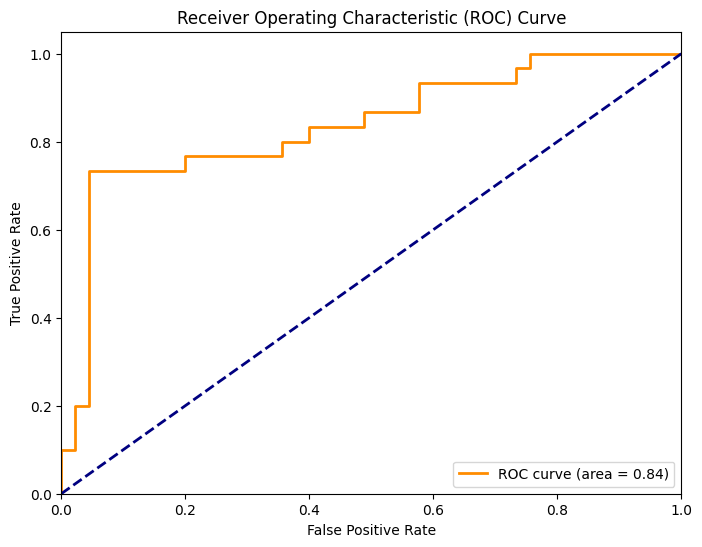

In [ ]:
# Using a random forest
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


# Splitting the pd_features into features and outcome
X = pd_features  # Features (excluding the 'Input' column)
y = pd_features_total['Class']  # Outcome (the 'Input' column)

# Splitting the dataset into training (80%) and a temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)

# Splitting the temporary set into validation and test sets (each 10% of the total dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Checking the distribution in each set
distribution_train = y_train.value_counts(normalize=True)
distribution_val = y_val.value_counts(normalize=True)
distribution_test = y_test.value_counts(normalize=True)

(distribution_train, distribution_val, distribution_test)

print(X_train.shape, X_val.shape)


clf = RandomForestClassifier(n_estimators=2000, random_state=0)
clf.fit(X_train, y_train)

# Predict probabilities for the validation set
y_probs = clf.predict_proba(X_val)[:, 1]  # get the probabilities for the positive class

# Calculate ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = roc_auc_score(y_val, y_probs)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Choose a threshold (here, the default 0.5 is used)
threshold = 0.5

# Convert probabilities to class predictions
y_pred = (y_probs > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

print("Confusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[31 14]
 [ 7 23]]


Feature ranking:
1. feature low_time_onset_peak (0.07293547240598477)
2. feature smooth_std_spectral_entropy (0.05402896667445048)
3. feature low_time_onset_max_peak (0.040002821669484497)
4. feature low_std_time_onset_peak (0.0386844614041753)
5. feature raw_std_spectral_entropy (0.038070943590538746)
6. feature smooth_time_onset_peak (0.03131487401369151)
7. feature smooth_time_onset_max_peak (0.029007368534001345)
8. feature low_std_time_onset_max_peak (0.023486759366760708)
9. feature raw_std_time_onset_max_peak (0.019107990654010143)
10. feature smooth_std_time_onset_peak (0.016860570686997024)
11. feature raw_time_onset_peak (0.014671015601837938)
12. feature low_std_spectral_entropy (0.013713906282661907)
13. feature raw_std_time_onset_peak (0.01263758860337422)
14. feature low_std_time_max (0.01153111413093668)
15. feature smooth_peak_to_peak (0.011518434713201143)
16. feature smooth_peaks_count_p2 (0.011500503020015181)
17. feature smooth_std_time_onset_max_peak (0.01085744302

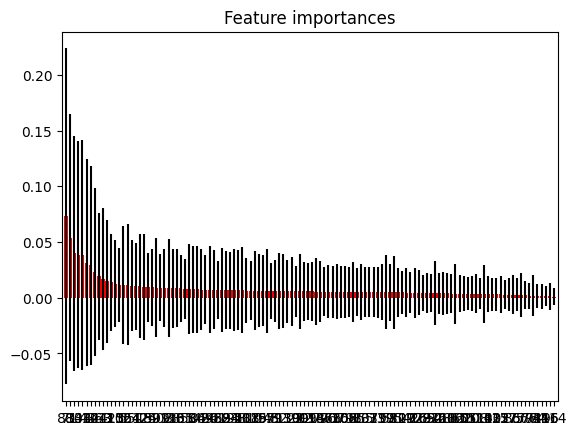

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {total_feature_columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


# Comparing the automated features versus the manual features

In [ ]:
def to_float(s):
    # Check if the input is already a float
    if isinstance(s, float):
        return s  # Return the float as is

    try:
        # Attempt to remove commas and convert to float
        return float(s.replace(',', ''))
    except ValueError:
        return np.nan  # or some other value that indicates a bad value


AMP15 = pd.read_csv(drive_path + "Amplituderawdatavglut2.csv").loc[0:9].T
AMP15.columns =  ["AMP15_sweep_" + str(x) for x in range(len(AMP15.columns))]
AMP60 = pd.read_csv(drive_path + "Amplituderawdatavglut2.csv").loc[16:25].T
AMP60.columns =  ["AMP60_sweep_" + str(x) for x in range(len(AMP60.columns))]

AMP60 = AMP60.applymap(to_float)
AMP15 = AMP15.applymap(to_float)

AMP60["mean_AMP60"] = np.mean(AMP60.values, axis=1)
AMP15["mean_AMP15"] = np.mean(AMP15.values, axis=1)

MetadataVGLUT2 = pd.read_csv(drive_path + "MetadataVGLUT2.csv")[['recordings',"Cell Ids for me"]]
MetadataVGLUT2

AMP15["Cell Ids for me"] = AMP15.index.values.astype(int)
AMP60["Cell Ids for me"] = AMP60.index.values.astype(int)

AMP60 = AMP60.merge(MetadataVGLUT2, on="Cell Ids for me")
AMP15 = AMP15.merge(MetadataVGLUT2, on="Cell Ids for me")

pd_complete_overview = pd_features_total[pd_features_total["Line"]=="Vglut2"]
pd_complete_overview = pd_complete_overview.merge(AMP15[["Cell Ids for me","mean_AMP15"]], on="Cell Ids for me")
pd_complete_overview = pd_complete_overview.merge(AMP60[["Cell Ids for me","mean_AMP60"]], on="Cell Ids for me")
pd_complete_overview = pd_complete_overview.drop(["Date/filename","Cell Ids for me", "Line","Date_filename_modified","Class","filename"], axis=1)
pd_complete_overview[["mean_AMP15",'mean_AMP60',"raw_min","smooth_min","low_min"]].corr()

,mean_AMP15,mean_AMP60,raw_min,smooth_min,low_min
mean_AMP15,1.000000,0.595301,0.579090,0.587806,0.678247
mean_AMP60,0.595301,1.000000,0.996244,0.995856,0.956557
raw_min,0.579090,0.996244,1.000000,0.999454,0.954116
smooth_min,0.587806,0.995856,0.999454,1.000000,0.962223
low_min,0.678247,0.956557,0.954116,0.962223,1.000000


In [ ]:
AMP15 = pd.read_csv(drive_path + "Latencyrawdatavglut2.csv").loc[0:9].T
AMP15.columns =  ["AMP15_sweep_" + str(x) for x in range(len(AMP15.columns))]
AMP60 = pd.read_csv(drive_path + "Latencyrawdatavglut2.csv").loc[16:25].T
AMP60.columns =  ["AMP60_sweep_" + str(x) for x in range(len(AMP60.columns))]

AMP60 = AMP60.applymap(to_float)
AMP15 = AMP15.applymap(to_float)

AMP60["mean_AMP60"] = np.mean(AMP60.values, axis=1)
AMP15["mean_AMP15"] = np.mean(AMP15.values, axis=1)

MetadataVGLUT2 = pd.read_csv(drive_path + "MetadataVGLUT2.csv")[['recordings',"Cell Ids for me"]]
MetadataVGLUT2

AMP15["Cell Ids for me"] = AMP15.index.values.astype(int)
AMP60["Cell Ids for me"] = AMP60.index.values.astype(int)

AMP60 = AMP60.merge(MetadataVGLUT2, on="Cell Ids for me")
AMP15 = AMP15.merge(MetadataVGLUT2, on="Cell Ids for me")

pd_complete_overview = pd_features_total[pd_features_total["Line"]=="Vglut2"]
pd_complete_overview = pd_complete_overview.merge(AMP15[["Cell Ids for me","mean_AMP15"]], on="Cell Ids for me")
pd_complete_overview = pd_complete_overview.merge(AMP60[["Cell Ids for me","mean_AMP60"]], on="Cell Ids for me")
pd_complete_overview = pd_complete_overview.drop(["Date/filename","Cell Ids for me", "Line","Date_filename_modified","Class","filename"], axis=1)
pd_complete_overview[["mean_AMP15",'mean_AMP60',"raw_min","smooth_min","low_min"]].corr()

,mean_AMP15,mean_AMP60,raw_min,smooth_min,low_min
mean_AMP15,1.000000,0.595301,0.579090,0.587806,0.678247
mean_AMP60,0.595301,1.000000,0.996244,0.995856,0.956557
raw_min,0.579090,0.996244,1.000000,0.999454,0.954116
smooth_min,0.587806,0.995856,0.999454,1.000000,0.962223
low_min,0.678247,0.956557,0.954116,0.962223,1.000000


In [ ]:
pd_latency = pd.read_csv(drive_path + "Latencyrawdatavglut2.csv").T
pd_latency.columns =  ["Lat_sweep_" + str(x) for x in range(len(pd_latency.columns))]
pd_latency["mean_latency"] = np.mean(pd_latency.values, axis=1)
pd_latency["std_latency"] = np.std(pd_latency.values, axis=1)

pd_latency.applymap(to_float)
pd_latency["Cell Ids for me"] = pd_latency.index.values.astype(int)
pd_latency = pd_latency.merge(MetadataVGLUT2, on="Cell Ids for me")
pd_latency

pd_complete_overview = pd_features_total[pd_features_total["Line"]=="Vglut2"]
pd_complete_overview = pd_complete_overview.merge(pd_latency[["Cell Ids for me","mean_latency","std_latency"]], on="Cell Ids for me")
pd_complete_overview = pd_complete_overview.drop(["Date/filename","Cell Ids for me", "Line","Date_filename_modified","Class","filename"], axis=1)
pd_complete_overview[["mean_latency","raw_time_onset_peak","low_time_onset_peak","smooth_time_onset_peak"]].corr()

,mean_latency,raw_time_onset_peak,low_time_onset_peak,smooth_time_onset_peak
mean_latency,1.000000,0.455072,0.654977,0.569835
raw_time_onset_peak,0.455072,1.000000,0.675814,0.720881
low_time_onset_peak,0.654977,0.675814,1.000000,0.883368
smooth_time_onset_peak,0.569835,0.720881,0.883368,1.000000


In [ ]:
pd_complete_overview[["mean_latency","raw_time_max","low_time_max","smooth_time_max"]].corr()

,mean_latency,raw_time_max,low_time_max,smooth_time_max
mean_latency,1.000000,0.325145,0.353118,0.328824
raw_time_max,0.325145,1.000000,0.767633,0.805486
low_time_max,0.353118,0.767633,1.000000,0.834016
smooth_time_max,0.328824,0.805486,0.834016,1.000000


In [ ]:
pd_complete_overview[["mean_latency","raw_time_onset_max_peak","low_time_onset_max_peak","smooth_time_onset_max_peak"]].corr()

,mean_latency,raw_time_onset_max_peak,low_time_onset_max_peak,smooth_time_onset_max_peak
mean_latency,1.000000,0.469202,0.609546,0.473592
raw_time_onset_max_peak,0.469202,1.000000,0.397049,0.563146
low_time_onset_max_peak,0.609546,0.397049,1.000000,0.761717
smooth_time_onset_max_peak,0.473592,0.563146,0.761717,1.000000


In [ ]:
pd_complete_overview[["mean_latency","raw_time_onset_peak","low_time_onset_peak","smooth_time_onset_peak"]].corr()

,mean_latency,raw_time_onset_peak,low_time_onset_peak,smooth_time_onset_peak
mean_latency,1.000000,0.455072,0.654977,0.569835
raw_time_onset_peak,0.455072,1.000000,0.675814,0.720881
low_time_onset_peak,0.654977,0.675814,1.000000,0.883368
smooth_time_onset_peak,0.569835,0.720881,0.883368,1.000000


In [ ]:
plt.plot(pd_complete_overview[[]])